**说实话,这个代码我不是很懂**

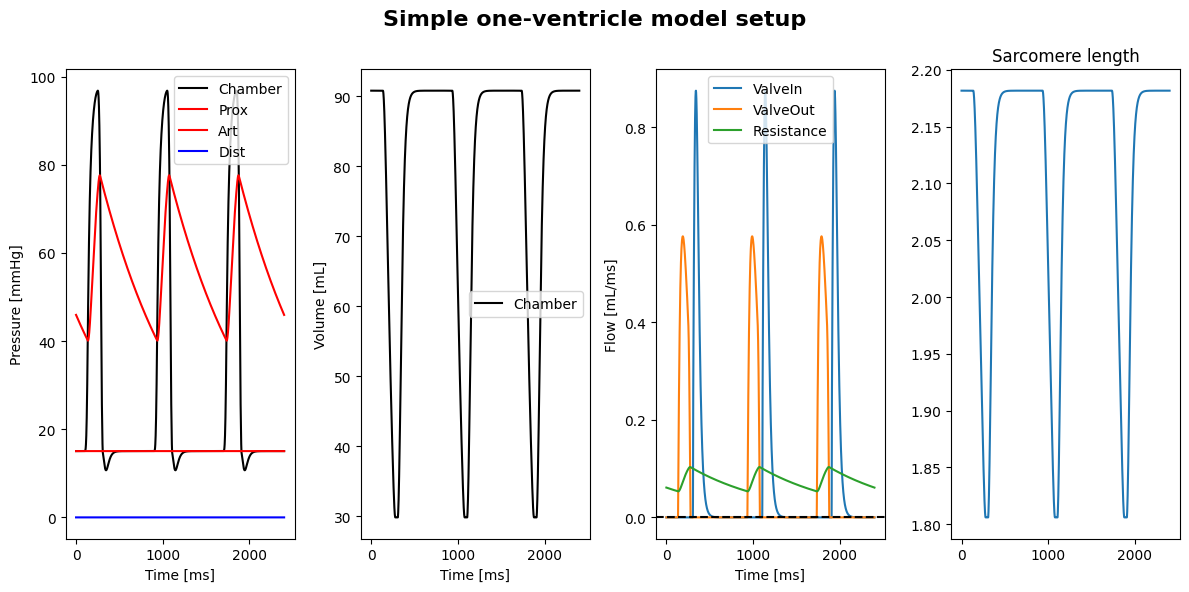

In [6]:
# -*- coding: utf-8 -*-
import sys
import os
# sys.path.append('../../../src/')

import circadapt
import circadapt.model
import circadapt.model.vanosta2024

import circadapt.plot

# Uncomment next lines if not installed
# circadapt.DEFAULT_PATH_TO_CIRCADAPT = os.getcwd() + "../../../../../CircAdapt_Library/out/build/x64-Release/CircAdaptLib.dll"


import circadapt

import addcopyfighandler
import matplotlib
matplotlib.rcParams['savefig.format'] = 'svg'

import numpy as np
import matplotlib.pyplot as plt

import time

def create_model():
    ###
    n_beat = 1

    dt = 0.001
    solver = "forward_euler"

    # open model
    model = circadapt.CircAdapt(solver)

    model['Solver']['dt'] = dt
    model['Solver']['dt_export'] = dt

    # Add modules to the wrapper
    model.add('Chamber')
    model.add('Patch')
    model.add('NodePressure')
    model.add('Capacitor')
    model.add('Resistance')
    model.add('Diode')

    # Build the cavity C using a Chamber2022 object. This object automatically
    # gets an Wall object with no patches, so a patch must be added.
    model['Chamber'].add('C')
    model['Patch'].add('C.wC.P')

    # add windkessel
    model['NodePressure'].add('Prox')
    model['NodePressure'].add('Dist')
    model['Capacitor'].add('Art')
    model['Resistance'].add('Resistance', prox='Art', dist='Dist')
    model['Diode'].add('ValveIn', prox='Prox', dist='C')
    model['Diode'].add('ValveOut', prox='C', dist='Art')

    # parameters
    # model.set('Model.Valve.R', 10)
    model.set('Model.ValveIn.R', 10e5)
    model.set('Model.ValveOut.R', 1e7)
    model.set('Model.Resistance.R', 1e8)
    model.set('Model.Art.C', 1e-8)

    # set proximal pressure
    model.set('Model.Prox.Pressure.set_time', 0)
    model.set('Model.Prox.Pressure.set_value', 2000)

    # set state variables
    model.set('Model.C.V', 10e-6)
    # model.set('Model.SyArt.V',   200e-6)
    # model.set('Model.SyVen.V',   300e-6)

    # parameterize patch
    model['Patch']['dt'] = 0.1
    model['Patch']['Sf_act'] = 100e3
    model['Patch']['Sf_pas'] = 1e3
    model['Patch']['Am_ref'] = 0.011
    model['Patch']['k1'] = 10
    model['Patch']['v_max'] = 7
    model['Patch']['V_wall'] = 1e-04
    model['Patch']['tr'] = 0.25
    model['Patch']['td'] = 0.25
    model['Patch']['time_act'] =  0.2
    model.set('Model.C.wC.P.l_si', 2.0)
    model.set('Model.Art.V', 10e-4)
    model.set('Model.Art.V0', 1e-4)
    # model.set('Model.Art.C', 2e-8)
    # model.set('Model.Art.V', 200)


    # model['Tube0D']['p0'][0] = 900
    # model['Tube0D']['A0'][0] = 6e-4

    # Run beats
    # t0 = time.time()
    # model.run(n_beat)
    # print(time.time()-t0)

    return model

# %% Run model and plot
if __name__ == '__main__':
    model = create_model()
    model['Solver']['store_beats'] = 3
    model.set('t_cycle', 0.8)
    model.run(15)


# %%
    plt.figure(1, clear=True, figsize=(12, 6))
    t = model['Solver']['t'] * 1e3

    m=1
    n=4

    ax = plt.subplot(m,n,1)
    ax.plot(t, model.get('Model.C.p')/133, label='Chamber', color='k')
    ax.plot(t, model.get('Model.Prox.p')/133, label='Prox', color='r')
    ax.plot(t, model.get('Model.Art.p')/133, label='Art', color='r')
    ax.plot(t, model.get('Model.Dist.p')/133, label='Dist', color='b')
    plt.legend()
    ax.set_ylabel('Pressure [mmHg]')
    ax.set_xlabel('Time [ms]')

    ax = plt.subplot(m,n,2)
    ax.plot(t, model.get('Model.C.V')*1e6, label='Chamber', color='k')
    ax.set_ylabel('Volume [mL]')
    ax.set_xlabel('Time [ms]')
    plt.legend()

    ax = plt.subplot(m,n,3)
    ax.plot(t, model.get('Model.ValveIn.q')*1e3, label='ValveIn')
    ax.plot(t, model.get('Model.ValveOut.q')*1e3, label='ValveOut')
    ax.plot(t, model.get('Model.Resistance.q')*1e3, label='Resistance')
    plt.legend()
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylabel('Flow [mL/ms]')
    ax.set_xlabel('Time [ms]')
    plt.legend()


    ax = plt.subplot(m,n,4)
    ax.plot(t, model['Patch']['l_s'], label='ValveIn')
    ax.set_title('Sarcomere length')

    plt.suptitle('Simple one-ventricle model setup', fontsize=16, weight='bold')


    # ax = plt.subplot(m,n,4)
    # ax.axhline(0, color='k', linestyle='--', lw=1)
    # ax.set_ylabel('C')
    # plt.legend()

    plt.tight_layout()
    plt.draw()
    plt.show()
